In [1]:
import pandas as pd
import numpy as np

In [3]:
train_df = pd.read_parquet("Data/train_final_v3.parquet")
val_df = pd.read_parquet("Data/validationA_v3.parquet")

In [5]:
print(train_df.shape)
print(val_df.shape)

(112768, 791)
(24164, 791)


In [7]:
train_df.iloc[:,:25].dtypes

category                            object
missing_price                         bool
item_rank                          float64
match                                int64
avg_rating                         float64
min_rating                           int64
percent_positive                   float64
percent_negative                   float64
avg_verified_reviewers             float64
min_date                    datetime64[ns]
max_date                    datetime64[ns]
product_lifespan           timedelta64[ns]
num_bots_per_asin                    int64
unique_reviewer_count                int64
avg_reviews_per_day                float64
reviews_per_product                  int64
avg_review_length_words            float64
embed_0                            float64
embed_1                            float64
embed_2                            float64
embed_3                            float64
embed_4                            float64
embed_5                            float64
embed_6    

In [105]:
X_train = train_df.drop(columns=['match'], axis=1)
X_val = val_df.drop(columns=['match'], axis=1)
y_train = train_df['match']
y_val = val_df['match']

## Columns Type Updated

In [107]:
for df in (X_train, X_val):
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)

for df in (X_train, X_val):
    df['missing_price'] = df['missing_price'].astype(int)

for df in (X_train, X_val):
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)

print(f"The shape of X_train: {X_train.shape}, X_val: {X_val.shape}")

The shape of X_train: (112768, 789), X_val: (24164, 789)


## Correlation Analysis

In [15]:
corr_matrix = X_train.drop(columns=['category'], axis=1).corr(method='pearson')  
# Get high-correlation pairs
high_corr = (corr_matrix.abs() > 0.9) & (corr_matrix.abs() < 1.0)
high_corr_pairs = high_corr.stack().loc[lambda x: x].reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

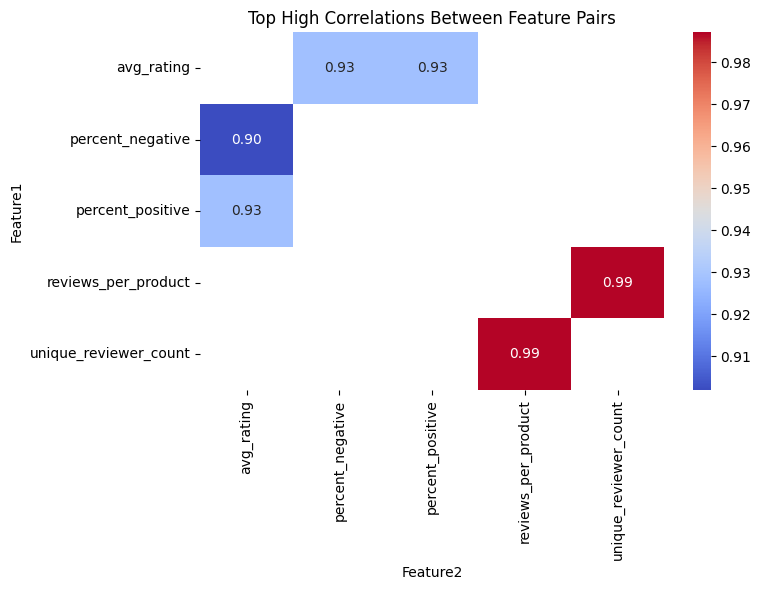

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top N correlated feature pairs
N = 50 
top_corr_pairs = high_corr_pairs.copy()
top_corr_pairs['AbsCorr'] = top_corr_pairs['Feature1'].map(
    lambda f1: corr_matrix.loc[f1, top_corr_pairs.loc[top_corr_pairs['Feature1'] == f1, 'Feature2']].values[0]
).abs()

top_corr_pairs = top_corr_pairs.sort_values('AbsCorr', ascending=False).head(N)

# Pivot for heatmap format
pivot_df = top_corr_pairs.pivot(index='Feature1', columns='Feature2', values='AbsCorr')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top High Correlations Between Feature Pairs")
plt.tight_layout()
plt.show()

We will drop the columns `percent_positive`, `percent_negative`, and `unique_reviewer_count` as they exhibit high correlation with other features, which may introduce multicollinearity into the model.

In [109]:
for df in (X_train, X_val):
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count'], axis=1, inplace=True)

## Preprocessing of Embedding and Nonembedding Columns

In [111]:
from typing import List, Tuple
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def build_preprocessor(X_train, X_val, *, embedding_prefix = "emb", categorical_cols = ["category"], drop_first = True):

    embedding_cols = [c for c in X_train.columns if c.startswith(embedding_prefix)]
    numeric_cols   = [c for c in X_train.columns if c not in categorical_cols + embedding_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first" if drop_first else None,sparse_output=False,),categorical_cols,),
            ("emb", StandardScaler(), embedding_cols),
        ],
        verbose_feature_names_out=False,
    ).set_output(transform="pandas")

    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc   = preprocessor.transform(X_val)

    return preprocessor, X_train_proc, X_val_proc, embedding_cols, numeric_cols

In [113]:
preprocessor, X_train_proc, X_val_proc, embedding_cols, numeric_cols = build_preprocessor(X_train, X_val)
# keeps original indices and column names:
print(X_train_proc.shape)          
print(X_train_proc.columns[:20])   

(112768, 804)
Index(['missing_price', 'item_rank', 'avg_rating', 'min_rating',
       'avg_verified_reviewers', 'num_bots_per_asin', 'avg_reviews_per_day',
       'reviews_per_product', 'avg_review_length_words',
       'mean_sentiment_score', 'mean_complaint_similarity',
       'mean_shipping_similarity', 'max_complaint_similarity',
       'shipping_similarity_at_max_complaint',
       'sentiment_score_at_max_complaint', 'review_span',
       'product_lifespan_days', 'category_Arts & Crafts',
       'category_Baby & Toddler Toys', 'category_Building Toys'],
      dtype='object')


In [125]:
cat_dummy_cols = list(preprocessor.named_transformers_['cat'].get_feature_names_out(['category']))

# Multicollinearity: Variance Inflation Factor (VIF) On Non-Embedding Features:

In [119]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X_train_proc, numeric_cols, categorical_cols, thresh=10):
    nonembed_cols = numeric_cols + categorical_cols
    X_vif = X_train_proc[nonembed_cols].copy()

    # drop constant / near-constant columns
    const_cols = X_vif.columns[X_vif.std() < 1e-12]
    if len(const_cols):
        X_vif.drop(columns=const_cols, inplace=True)

    # VIF calculation 
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    # Print features with VIF > 10
    high_vif = vif_data[vif_data["VIF"] > thresh].sort_values("VIF", ascending=False)
    if not high_vif.empty:
        print(f"Features with VIF > {thresh}:")
        print(high_vif.to_string(index=False))
    else:
        print(f"No features with VIF > {thresh}")

    return vif_data

In [127]:
vif_data = compute_vif(X_train_proc, numeric_cols, cat_dummy_cols, thresh=10)

C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Features with VIF > 10:
              feature  VIF
          review_span  inf
product_lifespan_days  inf


We will drop review_span.

In [129]:
for df in (X_train, X_val):
    df.drop(['review_span'], axis=1, inplace=True)

In [131]:
preprocessor, X_train_proc, X_val_proc, embedding_cols, numeric_cols = build_preprocessor(X_train, X_val) 
cat_dummy_cols = list(preprocessor.named_transformers_['cat'].get_feature_names_out(['category']))
vif_data = compute_vif(X_train_proc, numeric_cols, categorical_cols, thresh=10)

No features with VIF > 10


## PCA On Enbedding Columns

In [141]:
from sklearn.decomposition import PCA

def add_pca_embeddings(X_train_proc,
                       X_val_proc,
                       embedding_cols,
                       nonembed_cols,
                       n_components=None,
                       explained_var=None,
                       random_state=42):
    # slice embedding block
    X_train_emb = X_train_proc[embedding_cols]
    X_val_emb   = X_val_proc[embedding_cols]

    # fit / transform PCA
    if explained_var is not None:
        pca = PCA(n_components=explained_var, random_state=random_state)
    else:
        pca = PCA(n_components=n_components, random_state=random_state)

    X_emb_train_pca = pca.fit_transform(X_train_emb)
    X_emb_val_pca   = pca.transform(X_val_emb)

    # build final feature names
    pca_names = [f"pca_emb_{i}" for i in range(X_emb_train_pca.shape[1])]
    final_cols = nonembed_cols + pca_names

    # concatenate non-embedding block with new PCA columns
    X_train_final = pd.DataFrame(
        np.hstack([X_train_proc[nonembed_cols].values, X_emb_train_pca]),
        columns=final_cols,
        index=X_train_proc.index
    )

    X_val_final = pd.DataFrame(
        np.hstack([X_val_proc[nonembed_cols].values, X_emb_val_pca]),
        columns=final_cols,
        index=X_val_proc.index
    )

    return X_train_final, X_val_final, pca, final_cols


In [145]:
nonembed_cols = numeric_cols + cat_dummy_cols
X_train_final_df, X_val_final_df, pca, final_cols = add_pca_embeddings(
        X_train_proc,
        X_val_proc,
        embedding_cols,
        nonembed_cols,
        explained_var=0.95
)

## Generate Feature Processor Class After Those Preprocessing Steps:

In [197]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

class FeaturePreprocessor:
    def __init__(self, embedding_prefix="emb", categorical_cols=["category"], drop_first=True, pca_n=None, pca_var=None, random_state=42):
        self.embedding_prefix = embedding_prefix
        self.categorical_cols = categorical_cols
        self.drop_first = drop_first
        self.pca_n = pca_n
        self.pca_var = pca_var
        self.random_state = random_state
        self.preprocessor = None
        self.numeric_cols = None
        self.embedding_cols = None

    
    def _engineer(self, df):
        df = df.copy()
        df["review_span"] = (df["max_date"] - df["min_date"]).dt.days
        df["missing_price"] = df["missing_price"].astype(int)
        df["product_lifespan_days"] = df["product_lifespan"].dt.days
        df.drop(
            ["min_date","max_date","product_lifespan",
             "percent_positive","percent_negative",
             "unique_reviewer_count","review_span"],
            axis=1, inplace=True, errors="ignore")
        return df
   
    def _make_preprocessor(self, X):
        self.embedding_cols = [c for c in X.columns if c.startswith(self.embedding_prefix)]
        self.numeric_cols   = [c for c in X.columns if c not in self.embedding_cols + self.categorical_cols]

        if self.pca_var is not None:
            pca = PCA(n_components=self.pca_var, random_state=self.random_state)
        else:
            pca = PCA(n_components=self.pca_n, random_state=self.random_state)

        emb_pipe = Pipeline([("scale", StandardScaler()),
                             ("pca",   pca)])

        pre = ColumnTransformer(
            [("num", StandardScaler(), self.numeric_cols),
             ("cat", OneHotEncoder(handle_unknown="ignore",
                                   drop="first" if self.drop_first else None,
                                   sparse_output=False),
                     self.categorical_cols),
             ("emb", emb_pipe, self.embedding_cols)],
            verbose_feature_names_out=False
        ).set_output(transform="pandas")
        return pre
   
    def fit(self, X):
        X_fe = self._engineer(X)
        self.preprocessor = self._make_preprocessor(X_fe)
        self.preprocessor.fit(X_fe)
        return self

    def _postprocess(self, X_df):
        pca_old = [c for c in X_df.columns if c.startswith("pca")]
        rename_map = {old: f"pca_emb_{i}" for i, old in enumerate(pca_old)}
        X_df = X_df.rename(columns=rename_map)
    
        cat_dummy = self.get_cat_dummy_cols()
        pca_cols  = [rename_map[c] for c in pca_old]   
        ordered   = self.numeric_cols + cat_dummy + pca_cols
        return X_df[ordered]

   
    def transform(self, X):
        X_fe = self._engineer(X)
        X_df = self.preprocessor.transform(X_fe)
        return self._postprocess(X_df)

    def fit_transform(self, X):
        X_fe = self._engineer(X)
        self.preprocessor = self._make_preprocessor(X_fe)
        X_df = self.preprocessor.fit_transform(X_fe)
        return self._postprocess(X_df)

    def get_cat_dummy_cols(self):
        return list(self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.categorical_cols))


In [201]:
# check both methods result in the same dataframe after preprocessing:
prep = FeaturePreprocessor(pca_var=0.95)

X_train_auto = prep.fit_transform(train_df.drop(columns=['match'], axis=1))
X_val_auto   = prep.transform(val_df.drop(columns=['match'], axis=1))

# get lists if needed
#numeric_cols  = prep.numeric_cols
#cat_dummy_cols = prep.get_cat_dummy_cols()

X_train_manual = X_train_final_df   
X_val_manual = X_val_final_df   

assert X_train_auto.equals(X_train_manual)  
assert X_val_auto.equals(X_val_manual)  
print(X_train_auto.columns[:10])            

Index(['missing_price', 'item_rank', 'avg_rating', 'min_rating',
       'avg_verified_reviewers', 'num_bots_per_asin', 'avg_reviews_per_day',
       'reviews_per_product', 'avg_review_length_words',
       'mean_sentiment_score'],
      dtype='object')


## Model Training:

In [205]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    average_precision_score, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

class ModelEvaluator:
    def __init__(self, model, average='binary', display_labels=None):
        self.model = model
        self.average = average
        self.display_labels = display_labels

    def evaluate_classification(self, y_true, y_pred, y_proba=None):
        prec = precision_score(y_true, y_pred, average=self.average)
        rec  = recall_score   (y_true, y_pred, average=self.average)
        f1   = f1_score       (y_true, y_pred, average=self.average)

        print(f"Precision: {prec:.3f}")
        print(f"Recall:    {rec:.3f}")
        print(f"F1-score:  {f1:.3f}")

        if y_proba is not None and self.average == 'binary':
            pr_auc  = average_precision_score(y_true, y_proba)
            roc_auc = roc_auc_score          (y_true, y_proba)
            print(f"PR  AUC:   {pr_auc:.3f}")
            print(f"ROC AUC:   {roc_auc:.3f}")

            # ROC curve
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            plt.figure(figsize=(4.5, 4.5))
            plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
            plt.plot([0, 1], [0, 1], 'k--', lw=0.8)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.tight_layout()
            plt.show()

        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=self.display_labels)
        fig, ax = plt.subplots(figsize=(4.5, 4.5))
        disp.plot(ax=ax, cmap='Blues', colorbar=False)
        ax.set_title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, feature_names, top_n=30):
        if hasattr(self.model, "feature_importances_"):
            importances = self.model.feature_importances_
            idx = importances.argsort()[::-1][:top_n]
            plt.figure(figsize=(8, 6))
            plt.barh(range(top_n), importances[idx][::-1])
            plt.yticks(range(top_n), [feature_names[i] for i in idx][::-1])
            plt.title("Top Feature Importances")
            plt.tight_layout()
            plt.show()

        elif hasattr(self.model, "coef_"):
            coefs = self.model.coef_.ravel()
            idx = np.abs(coefs).argsort()[::-1][:top_n]
            plt.figure(figsize=(8, 6))
            plt.barh(range(top_n), coefs[idx][::-1])
            plt.yticks(range(top_n), [feature_names[i] for i in idx][::-1])
            plt.axvline(0, color='k', lw=0.8)
            plt.title("Top Coefficients")
            plt.tight_layout()
            plt.show()
        else:
            print("Model has no feature-importance attribute.")

    def fit_and_evaluate(self, X_train, y_train, X_val, y_val):
        print("Training model …")
        self.model.fit(X_train, y_train)

        print("\nTraining Performance:")
        self.evaluate_classification(
            y_train,
            self.model.predict(X_train),
            self._get_proba(X_train)
        )

        print("\nValidation Performance:")
        self.evaluate_classification(
            y_val,
            self.model.predict(X_val),
            self._get_proba(X_val)
        )
        return self.model

    def _get_proba(self, X):
        if hasattr(self.model, "predict_proba"):
            return self.model.predict_proba(X)[:, 1]
        if hasattr(self.model, "decision_function"):
            return self.model.decision_function(X)
        return None


### Test PCA With  Logistic Regression

Training model …

📊 Training Performance:
Precision: 0.025
Recall:    0.826
F1-score:  0.049
PR  AUC:   0.056
ROC AUC:   0.874


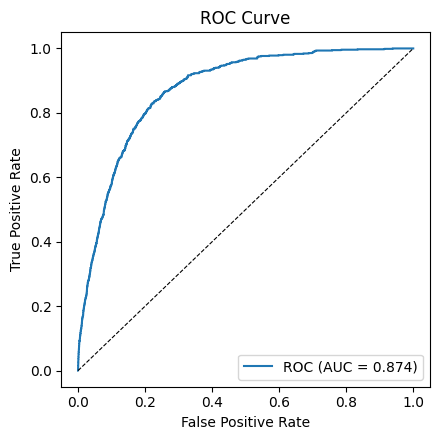


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88    112000
           1       0.03      0.83      0.05       768

    accuracy                           0.78    112768
   macro avg       0.51      0.80      0.46    112768
weighted avg       0.99      0.78      0.87    112768



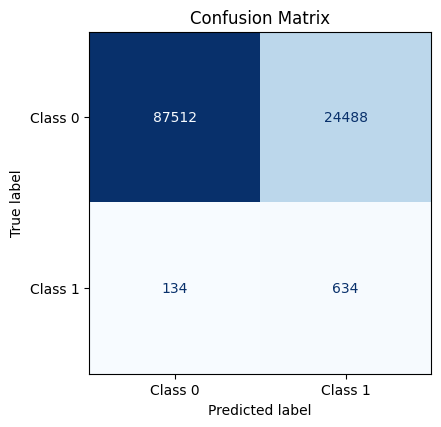


📈 Validation Performance:
Precision: 0.024
Recall:    0.793
F1-score:  0.046
PR  AUC:   0.042
ROC AUC:   0.841


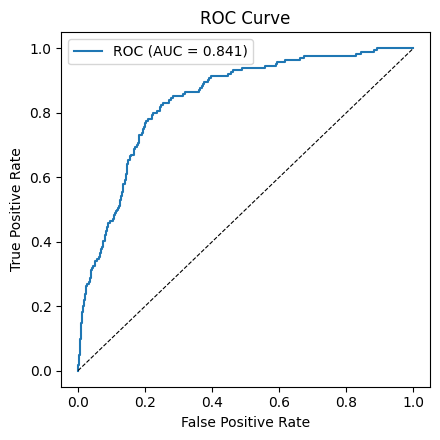


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.87     24000
           1       0.02      0.79      0.05       164

    accuracy                           0.78     24164
   macro avg       0.51      0.79      0.46     24164
weighted avg       0.99      0.78      0.87     24164



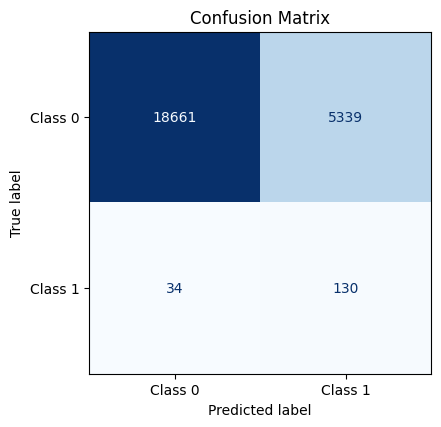

Training model …

📊 Training Performance:
Precision: 0.026
Recall:    0.826
F1-score:  0.050
PR  AUC:   0.062
ROC AUC:   0.882


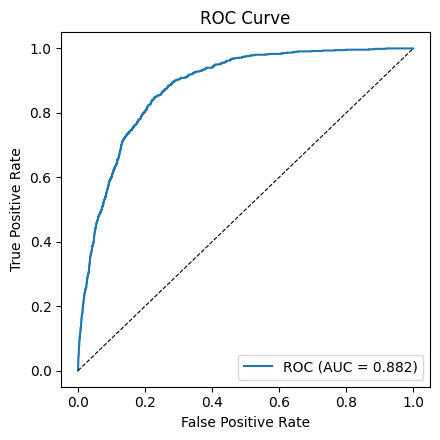


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    112000
           1       0.03      0.83      0.05       768

    accuracy                           0.79    112768
   macro avg       0.51      0.81      0.46    112768
weighted avg       0.99      0.79      0.87    112768



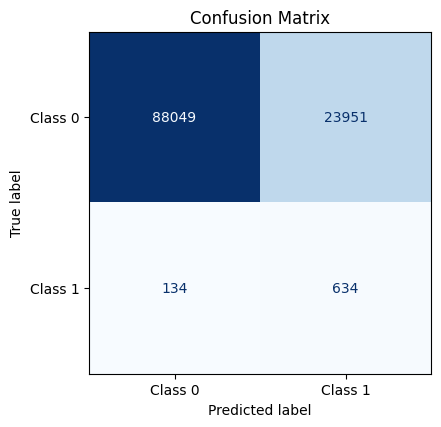


📈 Validation Performance:
Precision: 0.024
Recall:    0.780
F1-score:  0.047
PR  AUC:   0.039
ROC AUC:   0.841


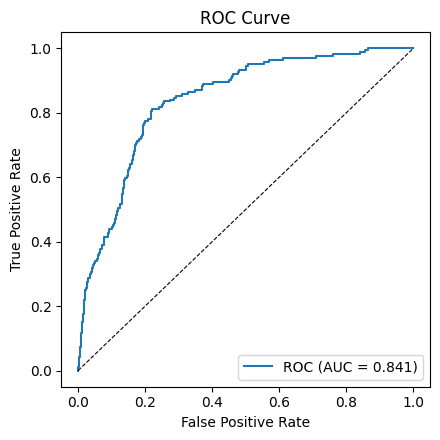


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88     24000
           1       0.02      0.78      0.05       164

    accuracy                           0.78     24164
   macro avg       0.51      0.78      0.46     24164
weighted avg       0.99      0.78      0.87     24164



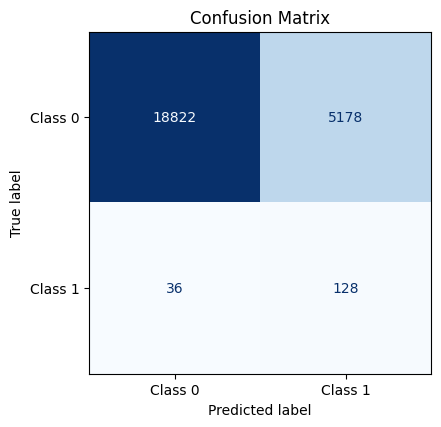

Training model …

📊 Training Performance:
Precision: 0.028
Recall:    0.839
F1-score:  0.053
PR  AUC:   0.072
ROC AUC:   0.892


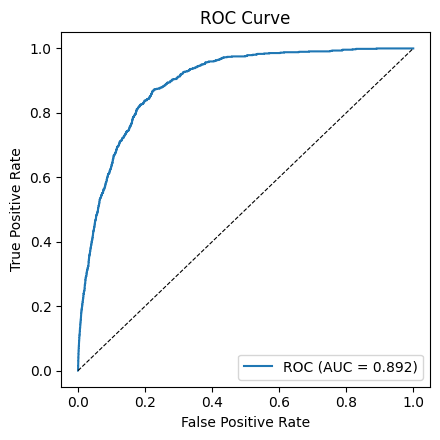


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    112000
           1       0.03      0.84      0.05       768

    accuracy                           0.80    112768
   macro avg       0.51      0.82      0.47    112768
weighted avg       0.99      0.80      0.88    112768



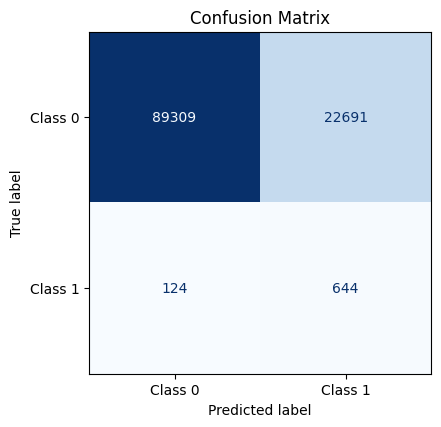


📈 Validation Performance:
Precision: 0.025
Recall:    0.756
F1-score:  0.048
PR  AUC:   0.038
ROC AUC:   0.843


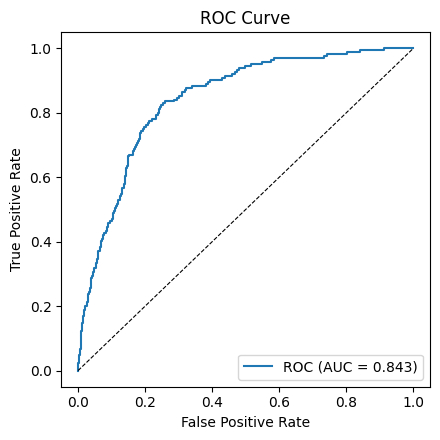


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89     24000
           1       0.02      0.76      0.05       164

    accuracy                           0.80     24164
   macro avg       0.51      0.78      0.47     24164
weighted avg       0.99      0.80      0.88     24164



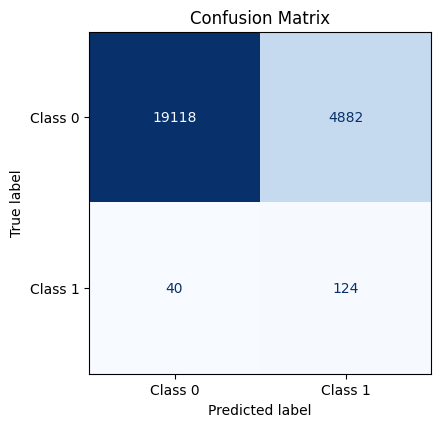

Training model …

📊 Training Performance:
Precision: 0.031
Recall:    0.859
F1-score:  0.059
PR  AUC:   0.085
ROC AUC:   0.908


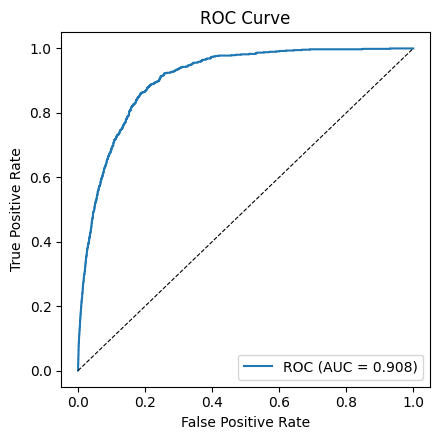


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.90    112000
           1       0.03      0.86      0.06       768

    accuracy                           0.81    112768
   macro avg       0.51      0.84      0.48    112768
weighted avg       0.99      0.81      0.89    112768



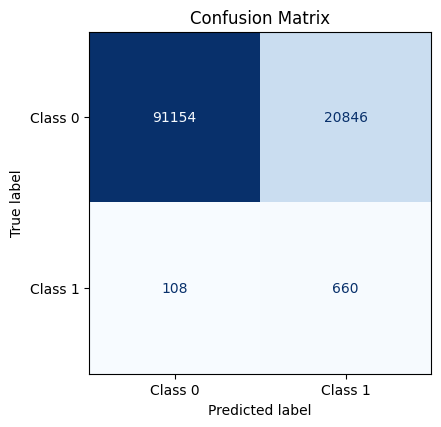


📈 Validation Performance:
Precision: 0.026
Recall:    0.756
F1-score:  0.051
PR  AUC:   0.032
ROC AUC:   0.850


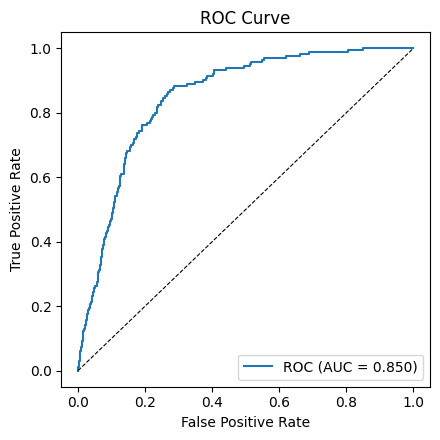


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89     24000
           1       0.03      0.76      0.05       164

    accuracy                           0.81     24164
   macro avg       0.51      0.78      0.47     24164
weighted avg       0.99      0.81      0.89     24164



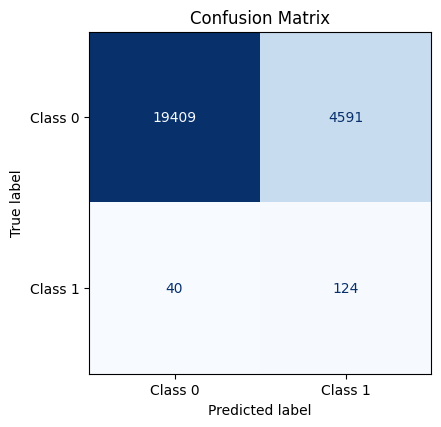

Training model …

📊 Training Performance:
Precision: 0.040
Recall:    0.909
F1-score:  0.076
PR  AUC:   0.104
ROC AUC:   0.939


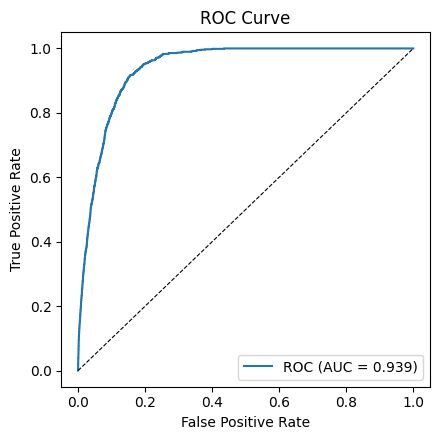


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    112000
           1       0.04      0.91      0.08       768

    accuracy                           0.85    112768
   macro avg       0.52      0.88      0.50    112768
weighted avg       0.99      0.85      0.91    112768



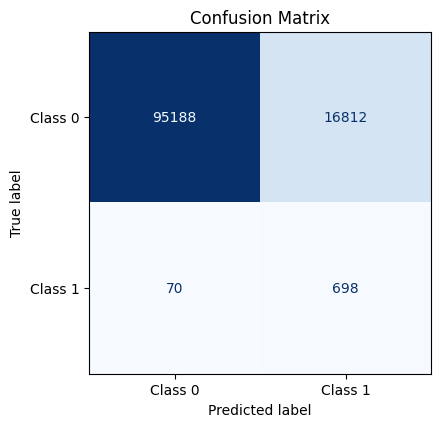


📈 Validation Performance:
Precision: 0.027
Recall:    0.640
F1-score:  0.052
PR  AUC:   0.028
ROC AUC:   0.833


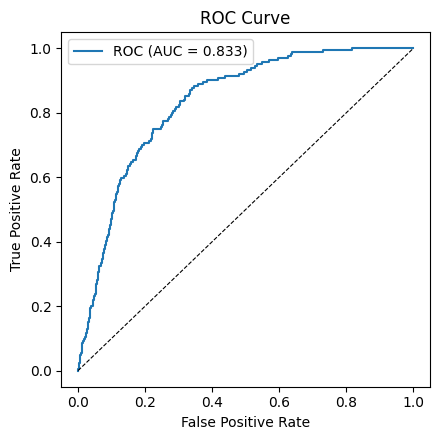


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91     24000
           1       0.03      0.64      0.05       164

    accuracy                           0.84     24164
   macro avg       0.51      0.74      0.48     24164
weighted avg       0.99      0.84      0.91     24164



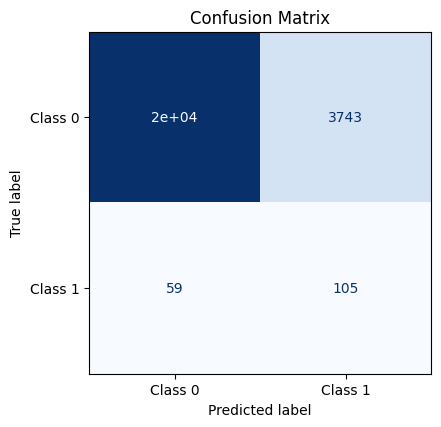

Training model …

📊 Training Performance:
Precision: 0.043
Recall:    0.921
F1-score:  0.083
PR  AUC:   0.106
ROC AUC:   0.947


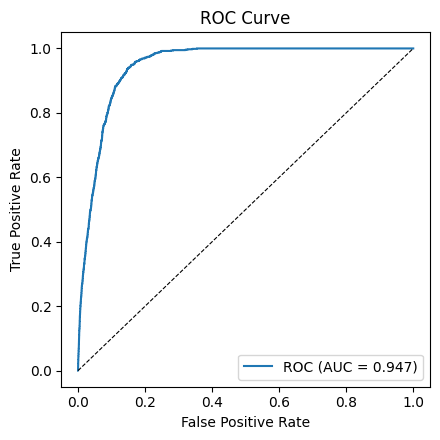


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92    112000
           1       0.04      0.92      0.08       768

    accuracy                           0.86    112768
   macro avg       0.52      0.89      0.50    112768
weighted avg       0.99      0.86      0.92    112768



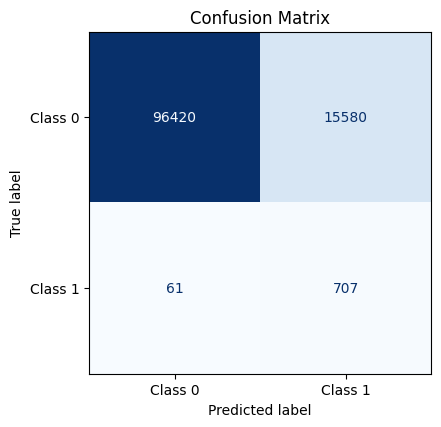


📈 Validation Performance:
Precision: 0.030
Recall:    0.640
F1-score:  0.056
PR  AUC:   0.029
ROC AUC:   0.829


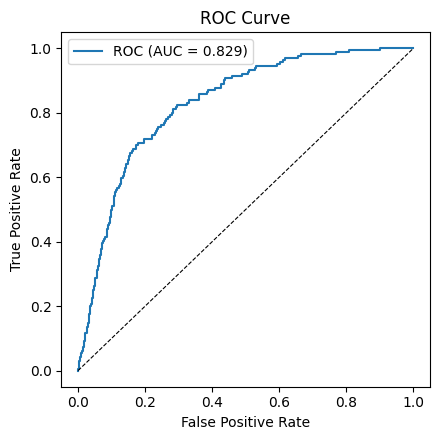


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92     24000
           1       0.03      0.64      0.06       164

    accuracy                           0.85     24164
   macro avg       0.51      0.75      0.49     24164
weighted avg       0.99      0.85      0.92     24164



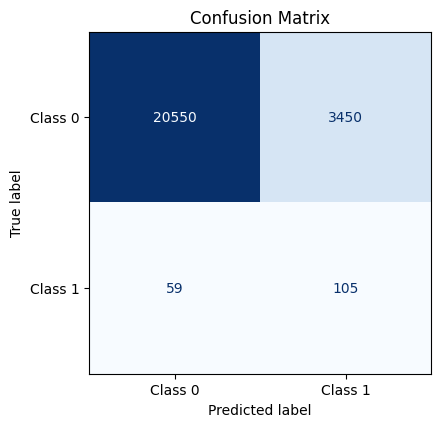


PCA grid summary
  setting  n_components    pr_auc   roc_auc
0    k_10            10  0.042170  0.841214
1    k_30            30  0.039459  0.840700
2    k_50            50  0.038146  0.842622
3   k_100           100  0.032265  0.849944
5  var_95           477  0.028549  0.829295
4  var_90           370  0.027958  0.833186


In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd

dims = [10, 30, 50, 100, 0.90, 0.95]          
results = []

for d in dims:
    if isinstance(d, float):
        X_tr, X_val_pca, pca, final_cols = add_pca_embeddings(
            X_train_proc, X_val_proc,
            embedding_cols, nonembed_cols,
            explained_var=d)
        tag = f"var_{int(d*100)}"
    else:
        X_tr, X_val_pca, pca, final_cols = add_pca_embeddings(
            X_train_proc, X_val_proc,
            embedding_cols, nonembed_cols,
            n_components=d)
        tag = f"k_{d}"

    # model evaluation 
    logreg = LogisticRegression(max_iter=1000,
                                class_weight="balanced",
                                random_state=42)

    evaluator = ModelEvaluator(
        model=logreg,
        average="binary",
        display_labels=["Class 0", "Class 1"]
    )

    evaluator.fit_and_evaluate(X_tr, y_train, X_val_pca, y_val)

    # collect summary metrics
    y_val_proba = logreg.predict_proba(X_val_pca)[:, 1]
    pr_auc  = average_precision_score(y_val, y_val_proba)
    roc_auc = roc_auc_score(y_val, y_val_proba)

    results.append({"setting": tag,
                    "n_components": pca.n_components_,
                    "pr_auc": pr_auc,
                    "roc_auc": roc_auc})

# tidy leaderboard
summary = pd.DataFrame(results).sort_values("pr_auc", ascending=False)
print("\nPCA grid summary")
print(summary)
